<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Evoked_Timescales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 🧠 Compute Evoked Signals for each subject using NPI.model_ECt
# ============================================

# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

# --- 6️⃣ Allowlist your model classes (needed for PyTorch ≥2.6) ---
torch.serialization.add_safe_globals(
    [NPI.ANN_MLP, NPI.ANN_CNN, NPI.ANN_RNN, NPI.ANN_VAR]
)

# --- 7️⃣ Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 229 (delta 25), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (229/229), 29.39 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (66/66), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


# Example simulate single subject time series

In [2]:
# Single subject plots
sig_path = os.path.join(preproc_dir, f"{subjects[0]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subjects[0]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subjects[0]}_targets.npy")
mdl_path = os.path.join(models_dir,  f"{subjects[0]}_MLP.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [8]:
S=3 #number of steps
N=Z.shape[1] #number of regions
M=500 # initial times to consider

dur=30 #predicted activity
pert_strength=0.1

Zsim=np.zeros((N, dur+3, N))
for node in range(2):
  print(node)
  for ini in range(M):
    # Build a perturbation that only hits the last step and a single node: (S, N)
    perturbation = np.zeros((S, N), dtype=float)
    perturbation[-1, node] = pert_strength

    init_cond=np.reshape(X[ini,:],(S,N))

    perturbed = NPI.model_time_series(model, init_cond + perturbation, tlen=dur, noise_strength=0.)
    unperturbed = NPI.model_time_series(model, init_cond, tlen=dur, noise_strength=0.)
    Zsim[node,:,:] += perturbed - unperturbed
  Zsim[node,:,:]/=M

0
1


In [9]:
Zsim.shape

(450, 33, 450)

In [10]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

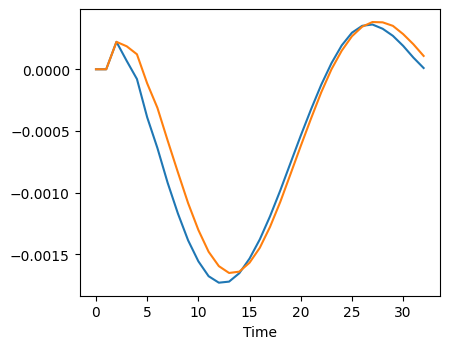

In [11]:
plt.figure(figsize=(4.6,3.6))
plt.plot(np.mean(Zsim[0,:,:],axis=1))
plt.plot(np.mean(Zsim[1,:,:],axis=1))
plt.xlabel('Time')
#plt.axis('off')
plt.tight_layout()
plt.show()

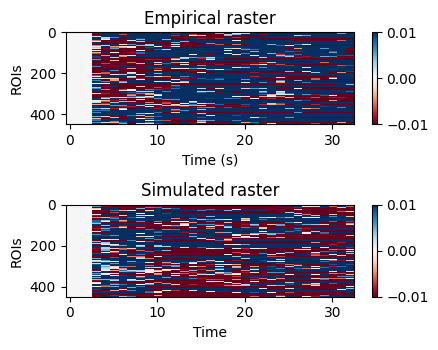

In [7]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(Zsim[0,:,:].T,aspect='auto',vmin=-.01,vmax=.01,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(Zsim[1,:,:].T,aspect='auto',vmin=-.01,vmax=.01,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')
#plt.axis('off')
plt.tight_layout()
plt.show()